# <b>Lab 2</b>: Classifications: Logistics, SVM, KNN, and RandomForest
# <center><font color='blue'>Student Exam Scores Extended Dataset</font></center> 
***
### <center><b> Team Members: </b> Joey Hernandez, Daniel Chang, and Vo Nguyen</center>

### <b> Contributions: </b>
- Logistic Model: Vo Nguyen
- KNN: Joey Hernandez
- RandomForest: Danny Chang

### <b>Table of Contents</b>
<a class="anchor" id="toc"></a>
* **[Data Preprocessing](#data)**
    * [Import Packages](#import)
    * [Loading the Data](#load)
    * [Dataset Cleaning: One-Hot Encoding](#hot)
    * [Response Variable into Categorical](#response)
* **[Logistic Regression](#logistic)**
* **[KNN](#knn)**
* **[RandomForest](#rf)**
* **[Conclusion](#conclusion)**

### Import Packages [↑](#toc)
<a class="anchor" id="import"></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
sns.set_style('whitegrid')

from sklearn.metrics import mean_squared_error

from sklearn.metrics import accuracy_score, confusion_matrix

### Loading the Data [↑](#toc)
<a class="anchor" id="load"></a>

In [2]:
df = pd.read_csv('cleandf.csv')
display(df)

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore,MathResult,ReadingResult,WritingResult
0,female,group C,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74,Pass,Pass,Pass
1,female,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,69,90,88,Fail,Pass,Pass
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91,Pass,Pass,Pass
3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,school_bus,5 - 10,45,56,42,Fail,Fail,Fail
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75,Pass,Pass,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30636,female,group D,high school,standard,none,single,sometimes,no,2.0,school_bus,5 - 10,59,61,65,Fail,Fail,Fail
30637,male,group E,high school,standard,none,single,regularly,no,1.0,private,5 - 10,58,53,51,Fail,Fail,Fail
30638,female,group C,high school,free/reduced,completed,married,sometimes,no,1.0,private,5 - 10,61,70,67,Fail,Pass,Fail
30639,female,group D,associate's degree,standard,completed,married,regularly,no,3.0,school_bus,5 - 10,82,90,93,Pass,Pass,Pass


### Dataset Cleaning: One-Hot Encode [↑](#toc)
<a class="anchor" id="hot"></a>

One Hot-Encode

In [3]:
df_dummy = pd.get_dummies(df, columns=['Gender', 'LunchType', 'TestPrep', 'IsFirstChild','TransportMeans'],
                          drop_first=True)
df_dummy["WklyStudyHours"] = [1 if x == '> 10' else 0 for x in df_dummy["WklyStudyHours"]]

df_dummy["PracticeSport"] = [0 if x == 'never' else 1 for x in df_dummy["PracticeSport"]]

math_df = df_dummy.drop(["ReadingResult", "WritingResult", "MathScore"], axis = 1)

math_df['HasSiblings'] = math_df['NrSiblings'].apply(lambda x: 1 if x > 0 else 0)

math_df.drop('NrSiblings', axis=1, inplace=True)

## Response Variable Math Test Score into Math Results Binary (Pass or Fail) [↑](#toc)
<a class="anchor" id="response"></a>

In [4]:
math_df['MathResultNum'] = np.where(math_df['MathResult'] == "Pass", 1, 0)

# Logistic Regression - Vo Nguyen  [↑](#toc)
<a class="anchor" id="logistic"></a>

### Import Packages for Logistics Regression

In [5]:
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
sns.set_style('whitegrid')
from pandas import Series,DataFrame
import numpy as np
import statsmodels.formula.api as smf

### Plot of our Target Variable
The plots have a slight imbalance dataset. We will proveed in comparing a regular 70-30 split to a Stratified 10-Fold CV to compare. Additionally, for the sake of our analysis, since we have a close imbalance dataset. We will not go with a oversamplgin resample function, but rather focus on adjusting the threshold according to our ROC.

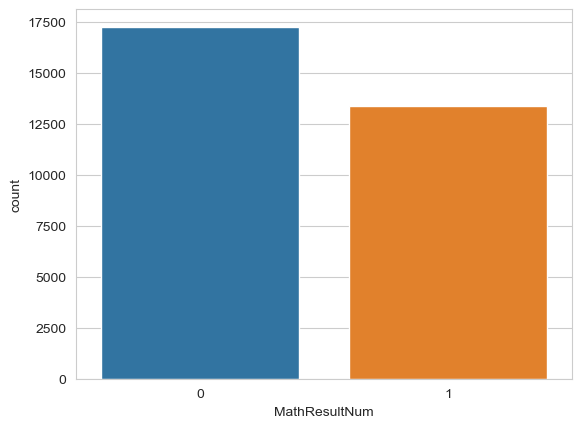

In [6]:
sns.countplot(data = math_df, x = 'MathResultNum')
plt.show()

Since we have an imbalance dataset. We can use the Receiver Operating Characteristic(ROC) curve to the examin the area under curve (AUC). The threshold that maximmizes our trade-off between true positive(sensitivity) and false posited rate can be a considered a good theshold for our classification. 

### Logistic Regression Model Summary

In [7]:
# building the model and fitting the data
Target = math_df["MathResultNum"]
feature_columns = math_df.drop(["EthnicGroup", "ParentEduc", "ParentMaritalStatus", "MathResult", "HasSiblings","MathResultNum"], axis = 1)
formula = "MathResultNum ~ " + " + ".join(feature_columns)

log_reg = smf.logit(formula, data=math_df).fit()

print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.264558
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          MathResultNum   No. Observations:                30641
Model:                          Logit   Df Residuals:                    30631
Method:                           MLE   Df Model:                            9
Date:                Wed, 28 Jun 2023   Pseudo R-squ.:                  0.6138
Time:                        18:46:52   Log-Likelihood:                -8106.3
converged:                       True   LL-Null:                       -20993.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -24.1572      0.302    -79.999      0.000     -24.

## External Cross Validation using SKLEARN

### Training a Logistic Regression Model 70-30 split

In [8]:
Train, Test= train_test_split(math_df, train_size = .7, test_size= .3, random_state=5)

X_train = Train.drop(["EthnicGroup", "ParentEduc", "ParentMaritalStatus", "MathResult", "HasSiblings","MathResultNum"], axis = 1)
y_train = Train.MathResultNum

X_test = Test.drop(["EthnicGroup", "ParentEduc", "ParentMaritalStatus", "MathResult", "HasSiblings","MathResultNum"], axis = 1)
y_test = Test.MathResultNum

#Create Logistic Classifier and Fit
clf = LogisticRegression(random_state=0).fit(X_train,y_train)

#Create Prediction Set
preds1 = clf.predict(X_test)

#Accuracy Method 1
print("Accuracy:",metrics.accuracy_score(y_test, preds1))

#RMSE
MSE = mean_squared_error(y_test,preds1)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)

Accuracy: 0.8829544218427064
RMSE: 0.3421192455230977


### Stratified 10-Fold Cross Validation for Training the Logistic Regression Model

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

X = math_df[['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none']]
y = math_df['MathResultNum']

log_clf = LogisticRegression(random_state=0)

cross_val_scores = cross_val_score(log_clf, X, y, cv=10)

avg_accuracy = cross_val_scores.mean()

print("Average CV Score Accuracy:", avg_accuracy)

preds = cross_val_predict(log_clf, X, y, cv=10)

MSE = mean_squared_error(y,preds)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)


Average CV Score Accuracy: 0.8786920572112497
RMSE: 0.3482930537691049


**A Train 70-30 split and a Stratified 10-Fold Cross Validation are similar in terms of accuracy score and RMSE; however, we want to treat our imbalance dataset seriously, but we can to do what we did on the our previous mini lab**

### Plot the AUC

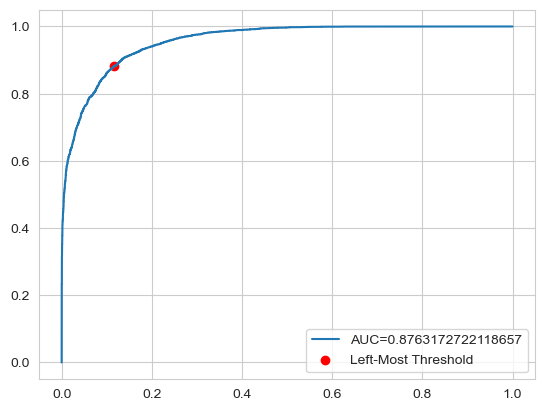

Optimal Threshold
0.38869958936818394
Recall
[0.00000000e+00 4.92368291e-04 7.38552437e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]



In [10]:
#Import Packages
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = clf.predict_proba(X_test)[:,1]
fpr,tpr, thresholds = roc_curve(y_test,y_pred_proba)

auc = metrics.roc_auc_score(y, preds)

#Find the Left Most Index
leftmost_index = np.nanargmin(np.abs(fpr - (1 - tpr)))
leftmost_fpr = fpr[leftmost_index]
leftmost_tpr = tpr[leftmost_index]

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.scatter(leftmost_fpr, leftmost_tpr, color='red', label="Left-Most Threshold")
plt.legend(loc=4)
plt.show()

#Optimal Threshhold
print("Optimal Threshold")
print(thresholds[np.argmax(tpr - fpr)])
print("Recall")
print(tpr)
print()


https://towardsdatascience.com/calculating-and-setting-thresholds-to-optimise-logistic-regression-performance-c77e6d112d7e

### Confusion Matrix for Logistic

[[4622  509]
 [ 567 3495]]


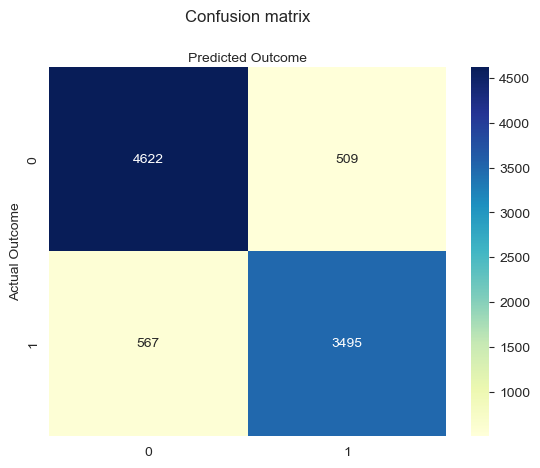

In [86]:
cnf_matrix = metrics.confusion_matrix(y_test, preds1)
print(cnf_matrix)

labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)


# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Outcome')
plt.xlabel('Predicted Outcome')
plt.show()

In [12]:
Performance = DataFrame({"Actual":y_test,"Predicted":preds1})
Performance["Subtract"] = Performance["Actual"]-Performance["Predicted"]
Accuracy = (Performance["Actual"].count() - sum(abs(Performance["Subtract"])))/Performance["Actual"].count()
print("Accuracy Method 2")
print(Accuracy)

from sklearn.metrics import classification_report
print(classification_report(y_test, preds1))
print("No Informaiton Rate")
print(np.mean(1-math_df["MathResultNum"]))

Accuracy Method 2
0.8829544218427064
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      5131
           1       0.87      0.86      0.87      4062

    accuracy                           0.88      9193
   macro avg       0.88      0.88      0.88      9193
weighted avg       0.88      0.88      0.88      9193

No Informaiton Rate
0.5632975425084038


### Reclassify on a Threshold of 0.39 and Examine CM Metrics using Stratified 10-Fold CV

In [13]:
log_clf = LogisticRegression(random_state=1)

threshold = 0.3886995893248815

log_clf.fit(X_train, y_train)

log_clf_probs = log_clf.predict_proba(X_test)[:,1]

preds = np.where(log_clf_probs >= threshold, 1, 0)

MSE = mean_squared_error(y_test,preds)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)


RMSE: 0.3427545650035033


### Confusion Matrix

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      5131
           1       0.84      0.90      0.87      4062

    accuracy                           0.88      9193
   macro avg       0.88      0.88      0.88      9193
weighted avg       0.89      0.88      0.88      9193

No Informaiton Rate
0.5632975425084038


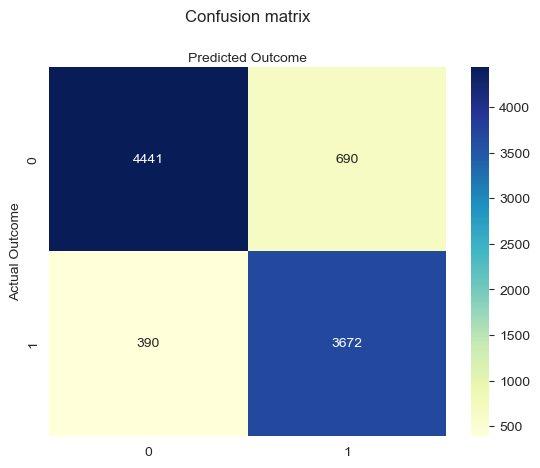

In [14]:
cnf_matrix = metrics.confusion_matrix(y_test, preds)

labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)


# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Outcome')
plt.xlabel('Predicted Outcome')

from sklearn.metrics import classification_report
print(classification_report(y_test, preds))
print("No Informaiton Rate")
print(np.mean(1-math_df["MathResultNum"]))

### Internal 5-Fold Cross Validation for Threshold of 0.39

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold


# prepare the cross-validation procedure
cv = KFold(n_splits=5, shuffle = True, random_state=1)

X = math_df[['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none']]
y = math_df['MathResultNum']

# create model
model = LogisticRegression(random_state=1).fit(X,y)
threshold = 0.3886995893248815



log_clf_probs = model.predict_proba(X)[:,1]
preds = np.where(log_clf_probs >= threshold, 1, 0)

probs = cross_val_predict(model, X, y, cv=5, method='predict_proba')
predicted_class = (probs[:, 1] > threshold).astype(int)

cv_score = accuracy_score(y, predicted_class)

print("Cross-validation score (accuracy):", cv_score)


# evaluate model
scoresAcc = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scoresRec = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
scoresPrec = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
scoresF1 = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)


# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scoresAcc), np.std(scoresAcc)))
print('Recall: %.3f (%.3f)' % (np.mean(scoresRec), np.std(scoresRec)))
print('Precision: %.3f (%.3f)' % (np.mean(scoresPrec), np.std(scoresPrec)))
print('F1: %.3f (%.3f)' % (np.mean(scoresF1), np.std(scoresF1)))

Cross-validation score (accuracy): 0.8764074279560067
Accuracy: 0.878 (0.003)
Recall: 0.857 (0.007)
Precision: 0.863 (0.006)
F1: 0.860 (0.003)


## Logistic Model Evaluation 

| Metric    | Threshold = 0.50 | Threshold = 0.39     |
|---------|-----|----------|
| **Accuracy**    | 0.88  | 0.88 |
|  **Precision**   | 0.88  | 0.89   |
| **Recall** | 0.88 | 0.88    |
| **F1 Score**  | 0.88  | 0.88    |
| **AUC-ROC**  | 0.87  | 0.88    |
| **RMSE**  | 0.342  | 0.342    |


### Advantages to Using Logistics Regression
- **Interpretability:** Logistics provides interpretability results as it can estimate the coefficients, thus we can use a simple odds ratio interpretation associated to each input feature. Additionally, the coefficient has a good interpretation of increasing or decreasing the response with a good cofidence interval. 
<br><br>
- **Probabilities:** Logistic Regression provides probability estimates for response. This is good because we can make business decision based on this confidnece level or want to analyze uncertainties of predictions. <br><br>
- **Robustness:** As you can see from our dataset, we have the ability to handle imbalance datasets more effectively by using appropriate techniques of thresholding.
<br><br>


# KNN - Joey  [↑](#toc)
<a class="anchor" id="logistic"></a>


## Import Packages for KNN, TTS, ETC

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

## View Occurances of MathResultNum

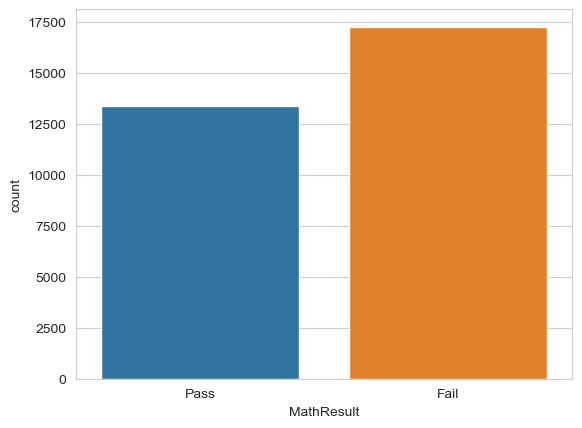

In [19]:
sns.countplot(data = math_df, x = 'MathResult')
plt.show()

### There seems to be evidence of a slight imbalance in our repsonse variable. Because of this we will proceed with Stratified Cross Validation for splitting up our data.

In [20]:
counts = math_df['MathResult'].value_counts()
ratio = counts[0] / counts[1]
print('Class Imbalance Ratio:', ratio)

Class Imbalance Ratio: 1.2898886480831029


## Normalize The continous Variables for use in KNN

Becuase our model will contain both binary variable and continuous variables we will normlize the two continuous variables to ensure that KNN is making accurate predictions. 

KNN is a distance based algorithm, meaning it will rely on measuring distance between data points to make predictions. When features have different scales, attributes with larger values may dominate the distance calcuations.

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_math_df = math_df
scale_math_df[['ReadingScore','WritingScore']] = scaler.fit_transform(math_df[['ReadingScore','WritingScore']])

### Setting Variables for X, Y

In [88]:
scale_math_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   EthnicGroup                30641 non-null  object 
 1   ParentEduc                 30641 non-null  object 
 2   ParentMaritalStatus        30641 non-null  object 
 3   PracticeSport              30641 non-null  int64  
 4   WklyStudyHours             30641 non-null  int64  
 5   ReadingScore               30641 non-null  float64
 6   WritingScore               30641 non-null  float64
 7   MathResult                 30641 non-null  object 
 8   Gender_male                30641 non-null  uint8  
 9   LunchType_standard         30641 non-null  uint8  
 10  TestPrep_none              30641 non-null  uint8  
 11  IsFirstChild_yes           30641 non-null  uint8  
 12  TransportMeans_school_bus  30641 non-null  uint8  
 13  HasSiblings                30641 non-null  int

In [22]:
X = scale_math_df[['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none']]
y = scale_math_df['MathResultNum']

### Initialize the KNN Classifier

In [23]:
knn = KNeighborsClassifier()

### Specifiy Params and perform Grid Search

In [24]:
param_grid = {'n_neighbors':[2,3,5,7,9,11,13,15,19]}

grid_search = GridSearchCV(knn, param_grid, cv = 5)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 5, 7, 9, 11, 13, 15, 19]})

### View Grid Search Results

Although the "best" accuracy is achieved with 19 Neighbors, we will proceed with using 9 neighbors. There is little improvement in accuracy after 9 neighbors and the added complexity to the model does not seem "worth" the small additon of accuracy.

In [25]:
grid_search_results = grid_search.cv_results_
print('Grid Search Results')
for mean_score, params in zip(grid_search_results['mean_test_score'], grid_search_results['params']):
    print(f'Parameters: {params} | Mean Accuracy: {mean_score}')

Grid Search Results
Parameters: {'n_neighbors': 2} | Mean Accuracy: 0.8294114527220888
Parameters: {'n_neighbors': 3} | Mean Accuracy: 0.8547370034254819
Parameters: {'n_neighbors': 5} | Mean Accuracy: 0.8627328313752154
Parameters: {'n_neighbors': 7} | Mean Accuracy: 0.8650174373255256
Parameters: {'n_neighbors': 9} | Mean Accuracy: 0.8686727152555991
Parameters: {'n_neighbors': 11} | Mean Accuracy: 0.870402427018408
Parameters: {'n_neighbors': 13} | Mean Accuracy: 0.8698802391319443
Parameters: {'n_neighbors': 15} | Mean Accuracy: 0.8720994697553515
Parameters: {'n_neighbors': 19} | Mean Accuracy: 0.8735680902374406


## View Best Results

In [26]:
best_knn = grid_search.best_estimator_
print(best_knn)

KNeighborsClassifier(n_neighbors=19)


## Running KNN with Desired k = 9 & Stratified 10 Fold Cross Validation

- Revisting the count plot for "Pass/Fail" instances above, we find that there is evidence which suggests a slight imbalance in our data exists. Because of this imbalance in our data we will proceed with a Stratified 10 Fold Cross Validation method for splitting our data. 

- Compared to the 'train_test_split' the Stratified Cross validation method allows us a bit more precision when working with an unbalanced response variable. 

In [27]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors = 9)

cross_val_scores = cross_val_score(knn, X, y, cv=10)

In [28]:
print('Cross-Validation Score:',cross_val_scores)

Cross-Validation Score: [0.8766721  0.86879896 0.87075718 0.87140992 0.86292428 0.87565274
 0.86781984 0.86814621 0.87369452 0.86390339]


In [29]:
avg_accuracy = cross_val_scores.mean()

print('Average Accuracy', avg_accuracy)

Average Accuracy 0.8699779154012923


In [30]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(knn, X, y, cv=10)

In [31]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)
print('RMSE', rmse)

RMSE 0.3605854491338837


# Model Evaluation

When evaluating KNN we will use the following metrics:

- **Confusion Matrix:** Provides tabular representation of the predicted versus acutal class labels. The confusion matrix 
allows for a detailed analysis of the model's performance and evaluation of different metrics (some of which we will include below)<br><br>

- **Accuracy:** Will help us to assess the overall Correctness of the model predictions. While it is not particualrly useful as a standalone metric it will provide a piece to a comprehensive look at our model performance.<br><br>

- **Precision:** It represents the proportion of correctly predicted positive instances (true positives) out of the total instances predicted as positive. Precision is useful when the cost of false positives is high, and we want to minimize false positives. It's important that we are able to identify students whom are classified as a "True Pass" so that we can ensure students are receiving the needed attention and help.<br><br>

- **Recall** Provides a measure for how many actual positive instances are correctly predicted as positive. "of all the positive instances how many are correctly predicted" This is important for us to understand so that we are not classiying students as "Pass" when they are actually likely to fail, which may prevent them from receiving the help they need.<br><br>

- **F1 Score:** By considering precision and recall simultaneously, the F1 score provides a balanced and comprehensive assessment of the model's performance for grade pass/fail classification. It helps in evaluating the model's ability to correctly identify both pass and fail cases, addressing imbalanced performance, and incorporating the potential costs associated with misclassifications in a meaningful way.<br><br>

- **AUC:** Represents the overall performance of the classifier across various classification thresholds. AUC-ROC is particularly useful when evaluating binary classification problems with imbalanced classes or when the emphasis is on ranking the instances.<br><br>

In [32]:
confusion_mat = confusion_matrix(y, y_pred)
print('Confusion Matrix', confusion_mat)

Confusion Matrix [[15218  2042]
 [ 1942 11439]]


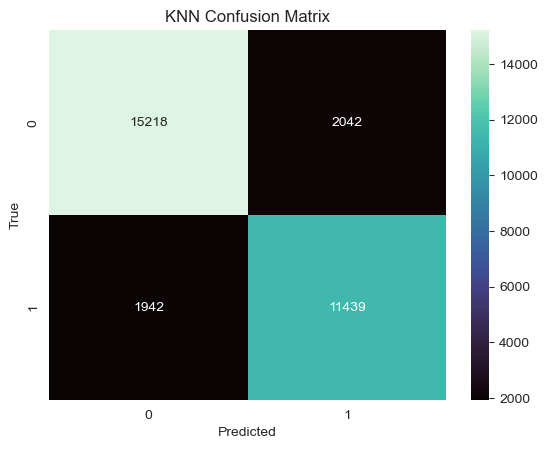

In [33]:
sns.heatmap(confusion_mat, annot=True, fmt = 'd', cmap = 'mako')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN Confusion Matrix')
plt.show()

In [34]:
TP = 11439 
FP = 2042
FN = 1942
TN = 15218

accuracy = (TP + TN)/ (TP + TN + FP + FN)
sensitivity = TP / (TP+FN)
specificity = TN / (TN+FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall)/ (precision + recall)

print('Accuracy', accuracy *100 ,'\n')
print('Sensitivity', sensitivity*100,'\n')
print('Specificity', specificity*100,'\n')
print('Precision', precision*100,'\n')
print('Recall', recall*100,'\n')
print('F1 - Score', f1_score*100,'\n')
print('RMSE', rmse)

Accuracy 86.99781338729153 

Sensitivity 85.4868843883118 

Specificity 88.16917728852839 

Precision 84.85275573028707 

Recall 85.4868843883118 

F1 - Score 85.16863971409427 

RMSE 0.3605854491338837


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))
print("No Informaiton Rate")
print(np.mean(1-math_df["MathResultNum"]))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     17260
           1       0.85      0.85      0.85     13381

    accuracy                           0.87     30641
   macro avg       0.87      0.87      0.87     30641
weighted avg       0.87      0.87      0.87     30641

No Informaiton Rate
0.5632975425084038


## ROC Curve

In [36]:
from sklearn.metrics import roc_curve, auc
y_scores = cross_val_predict(knn, X, y, cv= 10, method = 'predict_proba')[:,1]


# false/true postive & threshold
fpr, tpr, thresholds = roc_curve(y, y_scores)

#roc calc
roc_auc = auc(fpr, tpr)


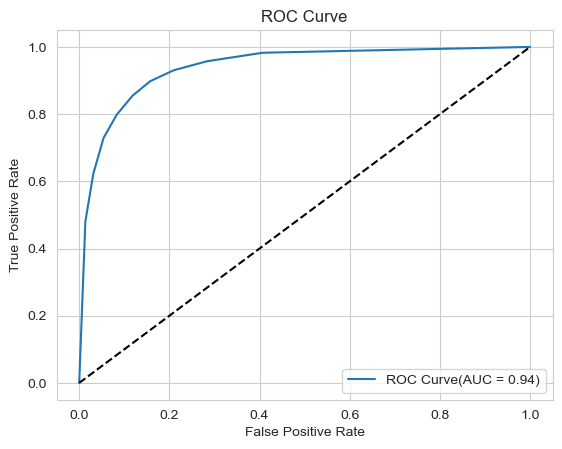

In [37]:
plt.plot(fpr, tpr, label = 'ROC Curve(AUC = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc= 'lower right')


plt.show()

The ROC Curve is represented by the line connecting the points defined by the False Positive Rate (FPR) on the x-axis and the True Positive Rate (TPR) on the y-axis. Each point on the curve corresponds to a different classification threshold. The curve visually illustrates the trade-off between the true positive rate and the false positive rate at different thresholds.

The AUC (Area under the curve) ranges from 0 to 1, where a higher value signifies better discriminative power and overall performance of the model. In this case our AUC is .94. 


### Analyzing Results

- **Accuracy:** 87

- **Precision:** 85

- **Recall:** 85

- **F1 Score:** 85.1

- **AUC-ROC:** 94

### Advantages to Using KNN

- **Simplicity:** KNN is a simple and intuitive algorithm that doesn't require complex assumptions or extensive parameter tuning. It is easy to understand and implement, making it accessible for users with limited machine learning experience. <br><br>
- **Flexibility:** KNN can handle both binary and continuous attributes, making it suitable for datasets with mixed data types. It can effectively incorporate different types of features into the classification process without requiring explicit feature engineering or transformation.
<br><br>
- **Non-linearity:** KNN is a non-parametric algorithm, meaning it doesn't make assumptions about the underlying data distribution. It can capture complex relationships and decision boundaries between features and the target variable, allowing for flexibility in modeling non-linear patterns.
<br><br>
- **Robustness to Outliers:** KNN is robust to outliers because it doesn't make strong assumptions about the data distribution. Outliers may have limited impact on the classification decision, as the majority vote is based on the nearest neighbors. This can be advantageous when dealing with datasets that contain noisy or inconsistent data.
<br><br>
- **Interpretability:** KNN provides interpretability as it can easily explain its predictions. The classification decision is based on the nearest neighbors, which can be visualized and understood by examining the neighboring instances and their corresponding class labels. This can be useful in scenarios where interpretability and explainability are important.
<br><br>
- **No Training Phase:** KNN is a lazy learning algorithm, meaning it does not have an explicit training phase. The model stores the entire training dataset and makes predictions at runtime based on the nearest neighbors. This allows for efficient adaptation to new data or incremental learning scenarios.

# Random Forest and Decision Tree - Danny

### Decision Tree

### Import Necessary Packages

In [38]:
import numpy as np
import pandas as pd

from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
sns.set_style('whitegrid')

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import sklearn.tree as tree

### Train a Decision Tree Model

In [39]:
X = scale_math_df[['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none']]
y = scale_math_df['MathResultNum']

DT_model = DecisionTreeClassifier(random_state=1,max_depth = 5).fit(X,y)

### Plot Decision Tree

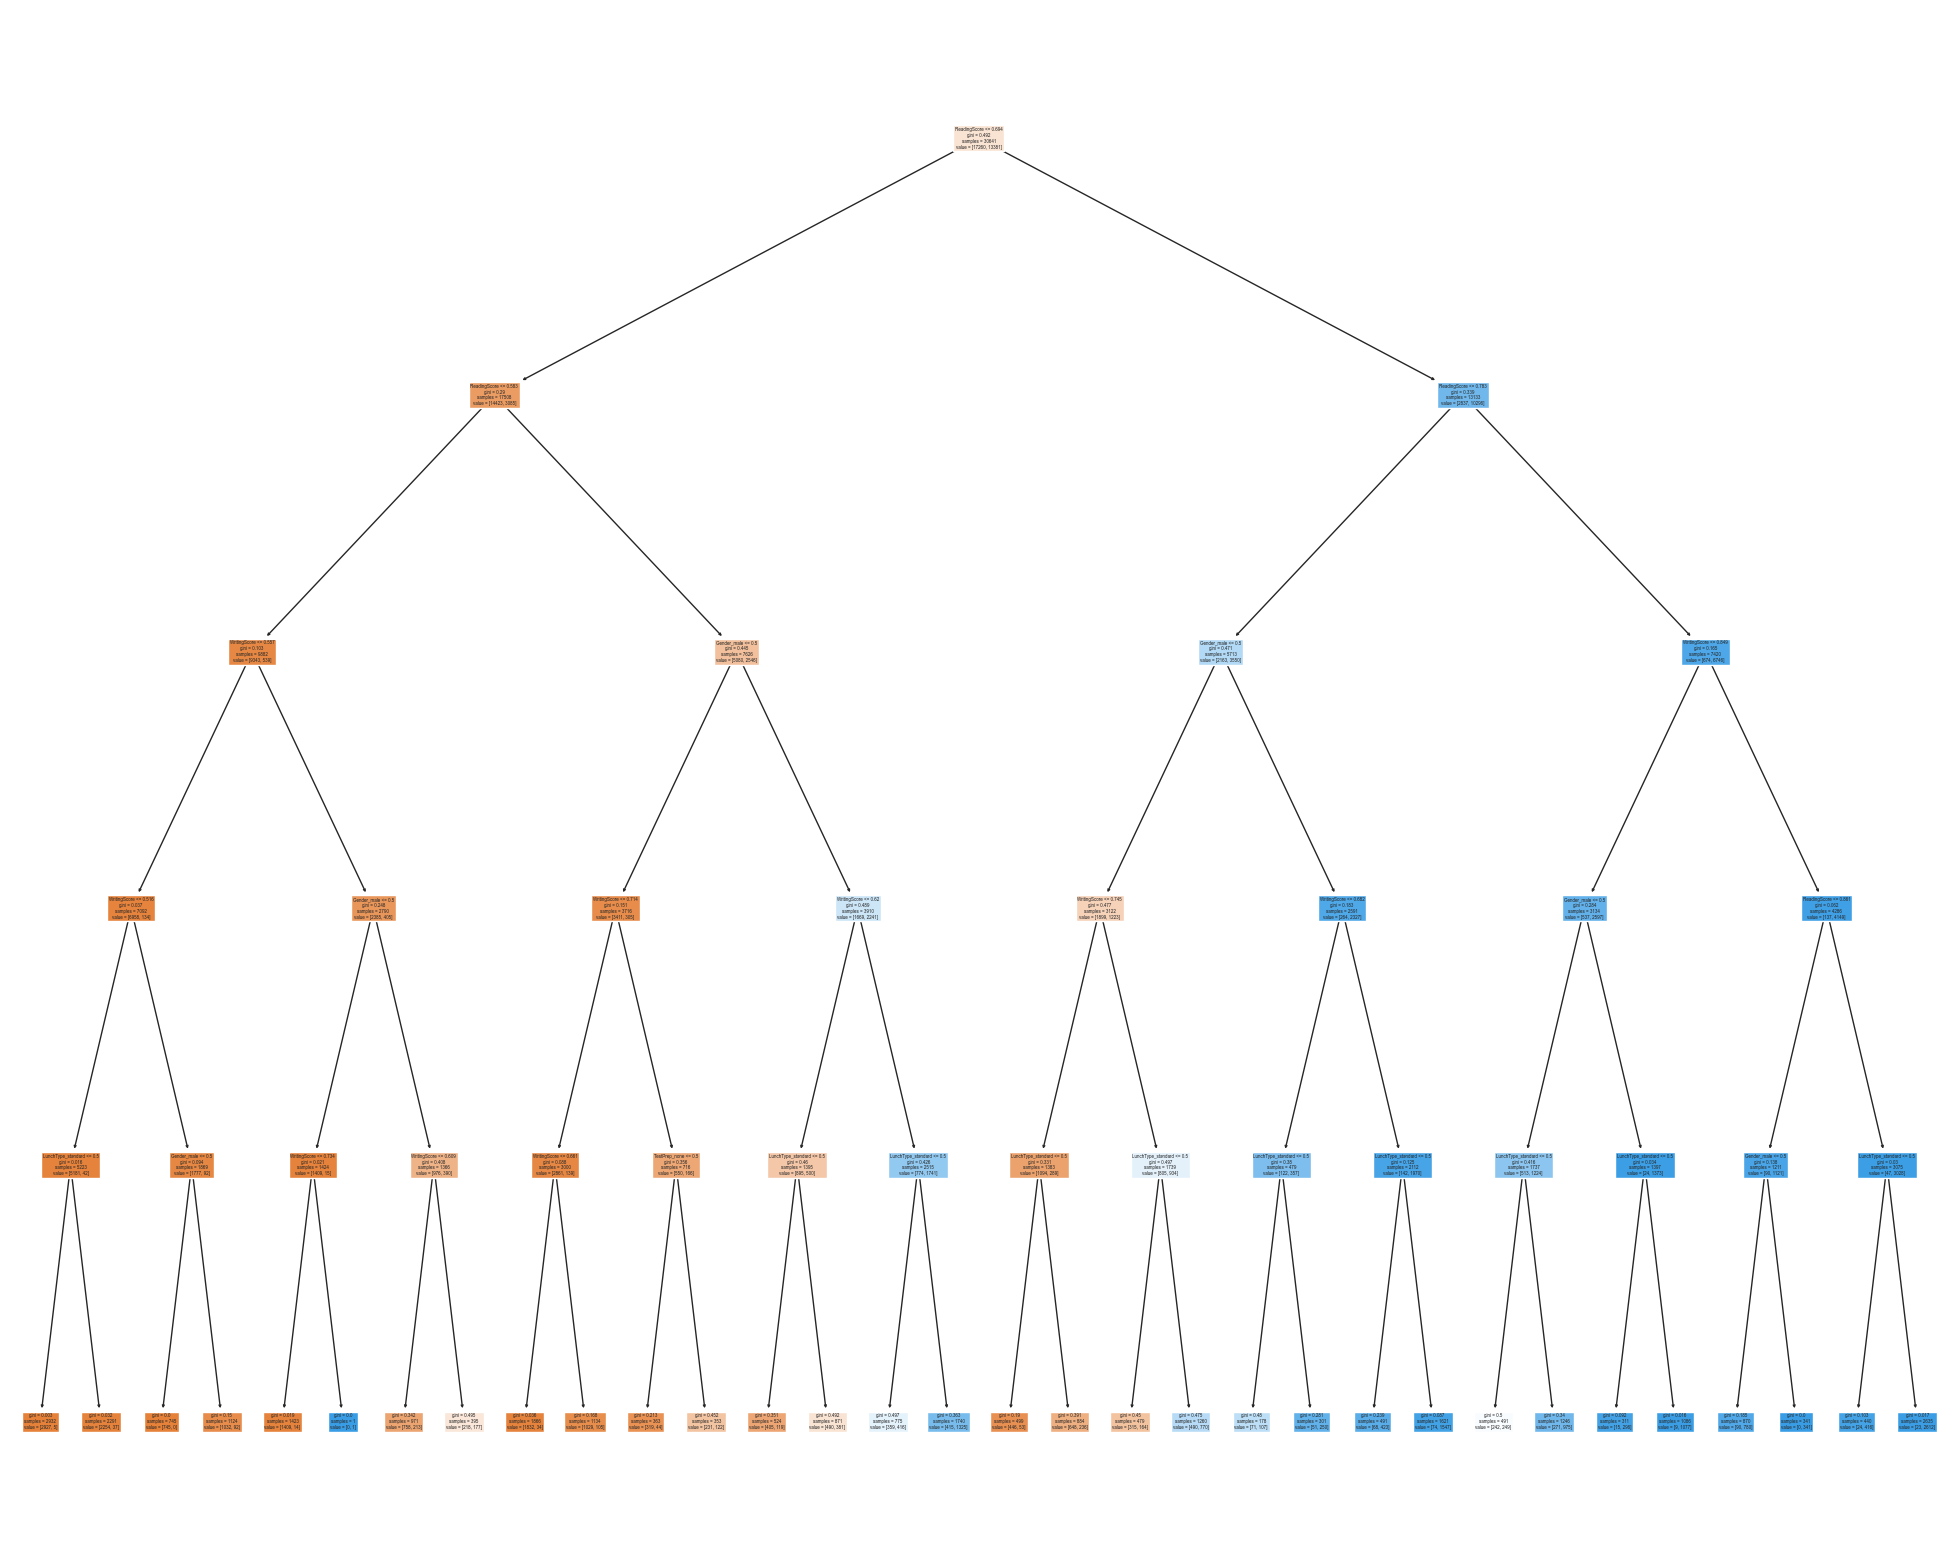

In [40]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DT_model, feature_names= np.array(['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none']), filled=True)

### Grid Search

In [41]:
from sklearn.model_selection import GridSearchCV
# Grid Search
#reformat for DT

cv = KFold(n_splits=10, shuffle = True, random_state=1)

a = GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1,2,3,4,5,6,7,8,9]}, cv = cv)
a.fit(X,y)
print('Best max_depth:', a.best_estimator_.get_params()['max_depth'])


Best max_depth: 8


### Internal 10 Cross Validation with Max-Depth = 7

In [42]:
DT_model = DecisionTreeClassifier(random_state = 1, max_depth = 7).fit(X,y)
predsProbs = DT_model.predict(X)
preds = list(map(round,predsProbs))
actual = y


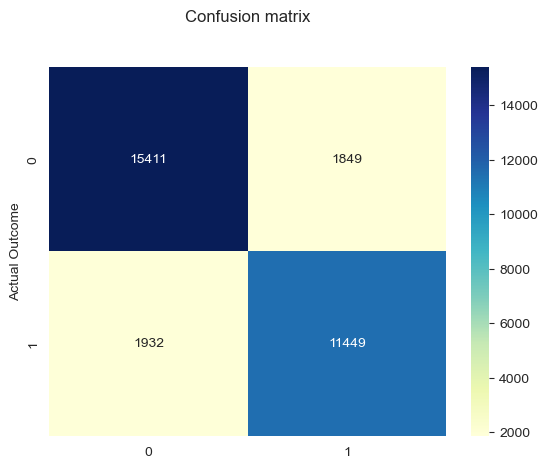

In [85]:
cnf_matrix = metrics.confusion_matrix(actual, preds)

labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Outcome')
plt.show()

In [44]:
scoresAcc = cross_val_score(DT_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scoresRec = cross_val_score(DT_model, X, y, scoring='recall', cv=cv, n_jobs=-1)
scoresPrec = cross_val_score(DT_model, X, y, scoring='precision', cv=cv, n_jobs=-1)
scoresF1 = cross_val_score(DT_model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scoresAcc), np.std(scoresAcc)))
print('Recall: %.3f (%.3f)' % (np.mean(scoresRec), np.std(scoresRec)))
print('Precision: %.3f (%.3f)' % (np.mean(scoresPrec), np.std(scoresPrec)))
print('F1: %.3f (%.3f)' % (np.mean(scoresF1), np.std(scoresF1)))


Accuracy: 0.874 (0.004)
Recall: 0.861 (0.008)
Precision: 0.853 (0.011)
F1: 0.857 (0.004)


In [45]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(DT_model, X, y, cv=10)

MSE = mean_squared_error(y,y_pred)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)


RMSE: 0.3545615781938417


### Feature Importance

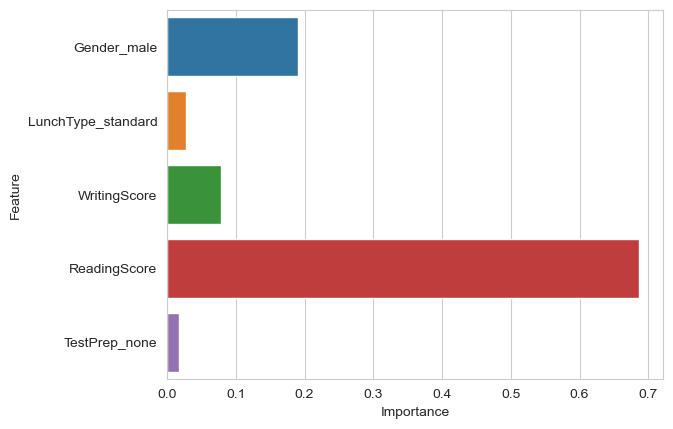

In [84]:
feature_importances = DT_model.feature_importances_

FI = pd.DataFrame({"Feature": ['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none'], "Importance": np.array(feature_importances)})

sns.barplot(y = "Feature", x = "Importance", data = FI)
plt.show()

**Feature Importance allows us to determine which feature is the singificant comparatively, and we see that reading score is a good feature in determining math test pass.**

# Random Forest - Daniel

### Grid Search

In [64]:
#Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Grid Search
#reformat for DT

X = math_df[['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none']]
y = math_df['MathResultNum']


cv = KFold(n_splits=5, shuffle = True, random_state=1)

a = GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [50,100,150,200],
                         'max_depth': [5,10],
                 'criterion' :['gini', 'entropy']}
 )
a.fit(X,y)
print('Best max_depth:', a.best_estimator_.get_params()['max_depth'])
print('Best number of trees:', a.best_estimator_.get_params()['n_estimators'])
print('Best Criterion:', a.best_estimator_.get_params()['criterion'])

Best max_depth: 5
Best number of trees: 50
Best Criterion: gini


### Fit the Forest and get Prediction

In [71]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

# Make a decision tree and train
RF = RandomForestClassifier(random_state=1, max_depth = 5, n_estimators = 100, criterion= 'entropy')
RF_model = RF.fit(X, y)

predsProbs = RF.predict(X)
preds = list(map(round,predsProbs))
actual = y

### Confusion Matrix

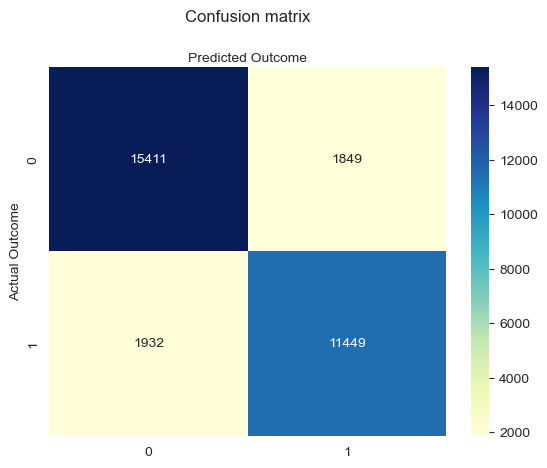

In [83]:
cnf_matrix = metrics.confusion_matrix(actual, preds)

labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Outcome')
plt.xlabel('Predicted Outcome')
plt.show()

In [73]:
from sklearn.metrics import classification_report
print(classification_report(actual, preds))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     17260
           1       0.86      0.86      0.86     13381

    accuracy                           0.88     30641
   macro avg       0.87      0.87      0.87     30641
weighted avg       0.88      0.88      0.88     30641



### Internal 10-Fold CV
Grid Search provided the best parameters as Max Depth = 10 and N_estimators = 100

In [77]:
# prepare the cross-validation procedure
#cv = KFold(n_splits=5, random_state=1, shuffle=True)
cv = KFold(n_splits=5, shuffle = True, random_state=1)
# create model
model = RandomForestClassifier(random_state = 1, max_depth = 5, n_estimators = 200)
# evaluate model

scoresAcc = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scoresRec = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
scoresPrec = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
scoresF1 = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scoresAcc), np.std(scoresAcc)))
print('Recall: %.3f (%.3f)' % (np.mean(scoresRec), np.std(scoresRec)))
print('Precision: %.3f (%.3f)' % (np.mean(scoresPrec), np.std(scoresPrec)))
print('F1: %.3f (%.3f)' % (np.mean(scoresF1), np.std(scoresF1)))

Accuracy: 0.875 (0.005)
Recall: 0.851 (0.006)
Precision: 0.861 (0.010)
F1: 0.856 (0.006)


In [78]:
MSE = mean_squared_error(actual,preds)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)


RMSE: 0.3512787439919315


**Comparing CV Results:**
Comparing CV results with our sinigle hold out, we see that both are very similar in terms of Accuracy, Recall, Precision, and F1. Good overall metrics hovering around 85%, which indicates a possible useful model.

### Feature Importance

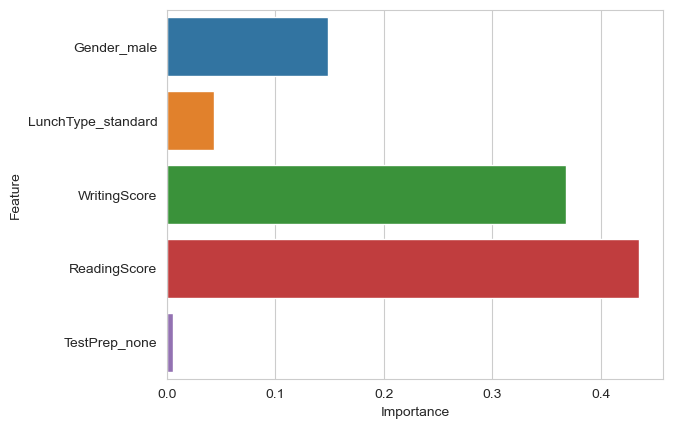

In [80]:
fi = RF.feature_importances_

FI = pd.DataFrame({"Feature": ['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none'], "Importance": np.array(fi)})
FI
sns.barplot(y = "Feature", x = "Importance", data = FI)
plt.show()

**Feature Importance Analysis:**
In our feature importance, we see that the Reading and Writing scores are highly valued features that can possibly be a useful explanatory variable for our response of students will pass the math test. It makes sense if you are a good reader and writer that you have a good chance to also pass a test. At the end of a day, you are taking a test, and if you are good at taking a test, math would probably have similar results.

### Comparing Results (Stratified 10-Fold Cross Validation)

| Metric    | Decision Tree | RandomForest  |
|---------|-----|----------|
| **Accuracy**    | 0.874  | 0.875 |
|  **Precision**   | 0.861  | 0.859   |
| **Recall** | 0.853 | 0.855   |
| **F1 Score**  | 0.857  | 0.855    |
| **RMSE**  | 0.354  | 0.352    |


### Advantages to Using Random Forest

- **Feature Importance:** Random Forest models provide a feature importance measure, which help us identify the influetial features in making predictions. This can help understand a relationship between the feature and target variable. <br><br>
- **Usefulness in High-Dimensional Data:** Random Forest can handle high-dimensional data effectively, as it automatically select informative features and split and ignore anything irrelevant. There are strong metrics usch as entrophy or gini to help reduce any noise.
<br><br>
- **Robustness to Noise and Outliers:** Random Forest models is the best out of our models in terms of being more robust to noisy data. The Random Forest aggregate predictions from multiple trees, reducing the impact of outliers and noisy istances.
<br><br>


# Process Recreation with More Features